## 1. Importing Basic Libraries

In [1]:
import numpy as np
import pandas as pd

import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.data import load
from collections import Counter
from sklearn import svm

import string
import re

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Importing ISOT Dataset (.csv)

ISOT_fake = pd.read_csv("./Dataset/Fake.csv")
ISOT_true = pd.read_csv("./Dataset/True.csv")

# Creating labels for each category of fake news

ISOT_fake["label"] = 1
ISOT_true["label"] = 0

# Importing FNN BuzzFeed dataset(.csv)

FNN_fake = pd.read_csv("./Dataset/BuzzFeed_fake_news_content.csv")
FNN_true = pd.read_csv("./Dataset/BuzzFeed_real_news_content.csv")

# Creating labels for each category of fake news

FNN_fake["label"] = 1
FNN_true["label"] = 0

In [3]:
print(ISOT_fake.shape)
print(FNN_fake.shape)

(23481, 5)
(91, 13)


In [4]:
ISOT_fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1

In [5]:
FNN_fake.head()

id                                              title  \
0   Fake_1-Webpage  Proof The Mainstream Media Is Manipulating The...   
1  Fake_10-Webpage  Charity: Clinton Foundation Distributed “Water...   
2  Fake_11-Webpage  A Hillary Clinton Administration May be Entire...   
3  Fake_12-Webpage  Trump’s Latest Campaign Promise May Be His Mos...   
4  Fake_13-Webpage                    Website is Down For Maintenance   

                                                text  \
0  I woke up this morning to find a variation of ...   
1  Former President Bill Clinton and his Clinton ...   
2  After collapsing just before trying to step in...   
3  Donald Trump is, well, deplorable. He’s sugges...   
4                    Website is Down For Maintenance   

                                                 url  \
0  http://www.addictinginfo.org/2016/09/19/proof-...   
1  http://eaglerising.com/36899/charity-clinton-f...   
2  http://eaglerising.com/36880/a-hillary-clinton...   
3  http://www.addictinginfo.org/2016/09/19/trumps...   
4  http://www.proudcons.com/clinton-foundation-ca...   

                                             top_img  \
0  http://addictinginfo.addictinginfoent.netdna-c...   
1  http://eaglerising.com/wp-content/uploads/2016...   
2  http://eaglerising.com/wp-content/uploads/2016...   
3  http://addictinginfo.addictinginfoent.netdna-c...   
4                                                NaN   

                       authors                        source  \
0              Wendy Gittleson  http://www.addictinginfo.org   
1               View All Posts        http://eaglerising.com   
2  View All Posts,Tony Elliott        http://eaglerising.com   
3                  John Prager  http://www.addictinginfo.org   
4                          NaN      http://www.proudcons.com   

               publish_date movies  \
0  {'$date': 1474243200000}    NaN   
1  {'$date': 1474416521000}    NaN   
2  {'$date': 1474416638000}    NaN   
3  {'$date': 1474243200000}    NaN   
4                       NaN    NaN   

                                              images  \
0  http://i.imgur.com/JeqZLhj.png,http://addictin...   
1  http://constitution.com/wp-content/uploads/201...   
2  http://constitution.com/wp-content/uploads/201...   
3  http://i.imgur.com/JeqZLhj.png,http://2.gravat...   
4                                                NaN   

                                      canonical_link  \
0  http://addictinginfo.com/2016/09/19/proof-the-...   
1  http://eaglerising.com/36899/charity-clinton-f...   
2  http://eaglerising.com/36880/a-hillary-clinton...   
3  http://addictinginfo.com/2016/09/19/trumps-lat...   
4                                                NaN   

                                           meta_data  label  
0  {"publisher": "Addicting Info | The Knowledge ...      1  
1  {"description": "The possibility that CHAI dis...      1  
2  {"description": "Hillary Clinton may be the fi...      1  
3  {"publisher": "Addicting Info | The Knowledge ...      1  
4  {"og": {"url": "http://www.proudcons.com", "ty...      1

### Combining both datasets into one (ISOT)

In [6]:
ISOT_df = pd.concat([ISOT_fake, ISOT_true])

# Remove irrelevant columns
ISOT_df.drop(['title', 'date'], axis=1, inplace=True)

# Removing rows with empty text

ISOT_df['text'].dropna(inplace = True)
ISOT_df.head()

text subject  label
0  Donald Trump just couldn t wish all Americans ...    News      1
1  House Intelligence Committee Chairman Devin Nu...    News      1
2  On Friday, it was revealed that former Milwauk...    News      1
3  On Christmas day, Donald Trump announced that ...    News      1
4  Pope Francis used his annual Christmas Day mes...    News      1

In [7]:
'''
Merged dataset with counts of labelled news where:
1 = fake news 
0 = true news

Total n of elements = 44,898
'''

ISOT_df.label.value_counts(dropna = False)

1    23481
0    21417
Name: label, dtype: int64

In [8]:
# Shuffle dataframe
from sklearn.utils import shuffle
ISOT_df = shuffle(ISOT_df)
ISOT_df = ISOT_df.reset_index(drop=True)

ISOT_df.head()

text      subject  label
0  The city s first transgender police officer wa...    left-news      1
1   In response to the establishment media s cont...  Middle-east      1
2  Martin Shkreli quickly gained notoriety during...         News      1
3  We pay our senators $174,000 per year. For tha...         News      1
4  SO YOUR HUSBAND TURNS 69 If he s Bill Clinton ...     politics      1

### Combining both datasets into one (FNN)

In [9]:
FNN_df = pd.concat([FNN_fake, FNN_true])

# Remove irrelevant columns
FNN_df.drop(['id','title','top_img','url','authors','publish_date','movies','images','canonical_link','meta_data'], axis=1, inplace=True)

# Removing rows with empty text

FNN_df['text'].dropna(inplace = True)

In [10]:
FNN_df.label.value_counts(dropna = False)

1    91
0    91
Name: label, dtype: int64

In [11]:
FNN_df = shuffle(FNN_df)
FNN_df = FNN_df.reset_index(drop=True)

FNN_df.head()

text  \
0  During a campaign stop in Philadelphia, Vice P...   
1  With the growing threat of terrorism around th...   
2  BOOM! Marines Send TERRORISTS Scathing Message...   
3  Lester Holt, who anchors "NBC Nightly News," w...   
4  Story highlights A final lab test of ISIS weap...   

                     source  label  
0            http://abcn.ws      0  
1       http://usherald.com      1  
2  http://rightwingnews.com      1  
3          http://politi.co      0  
4             http://cnn.it      0

## 2. Exploratory Dataset Analysis (EDA)

### 2.1 ISOT Dataset

First the true news dataset will be briefly explored followed by the fake news datset

In [12]:
ISOT_df_sub=ISOT_df.groupby(['subject', 'label'])['text'].count()
ISOT_df_sub

subject          label
Government News  1         1570
Middle-east      1          778
News             1         9050
US_News          1          783
left-news        1         4459
politics         1         6841
politicsNews     0        11272
worldnews        0        10145
Name: text, dtype: int64

In [13]:
ISOT_df_sub = ISOT_df_sub.unstack().fillna(0)
ISOT_df_sub

label                  0       1
subject                         
Government News      0.0  1570.0
Middle-east          0.0   778.0
News                 0.0  9050.0
US_News              0.0   783.0
left-news            0.0  4459.0
politics             0.0  6841.0
politicsNews     11272.0     0.0
worldnews        10145.0     0.0

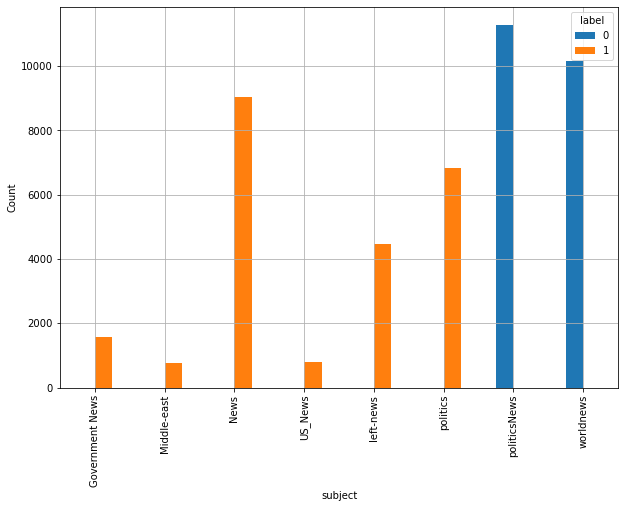

In [14]:
# Bar graph visualisation
sub_bargraph = (ISOT_df_sub).plot(kind='bar',figsize=(10, 7),grid=True)
sub_bargraph.set_ylabel('Count')
plt.show()

It can be seen that the true news (0) is equally distributed whereas fake news(1) is not equally distributed 
with true news being from the categories of 
* PoliticsNews
* WorldNews

### 2.1.1 Analyzing Ngrams

In [15]:
def clean_ngrams(text):
    
    stopwords = nltk.corpus.stopwords.words('english')
    wnl = nltk.stem.WordNetLemmatizer()
    
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [16]:
ISOT_df_ngram = clean_ngrams(''.join(str(ISOT_df['text'].tolist())))

In [17]:
ISOT_bigrams_series = (pd.Series(nltk.ngrams(ISOT_df_ngram, 2)).value_counts())[:20]
ISOT_trigrams_series  = (pd.Series(nltk.ngrams(ISOT_df_ngram, 3)).value_counts())[:20]

Text(0.5, 0, 'Count')

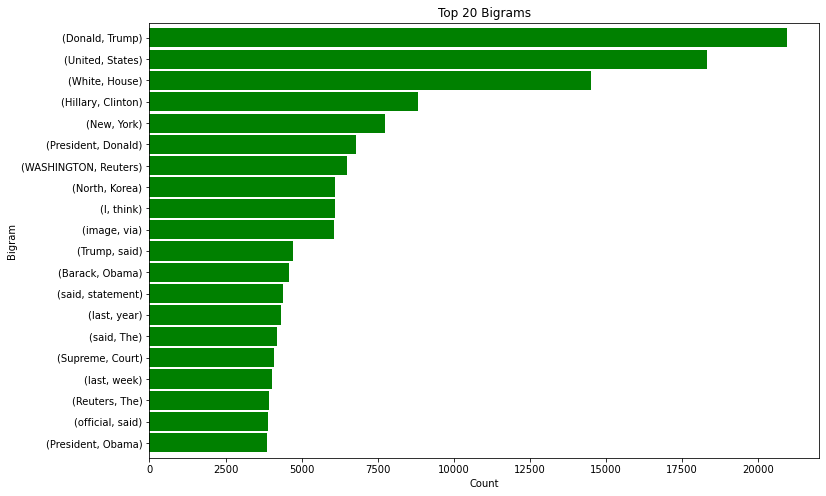

In [18]:
ISOT_bigrams_series.sort_values().plot.barh(color='green', width=.9, figsize=(12, 8))
plt.title('Top 20 Bigrams')
plt.ylabel('Bigram')
plt.xlabel('Count')

Text(0.5, 0, 'Count')

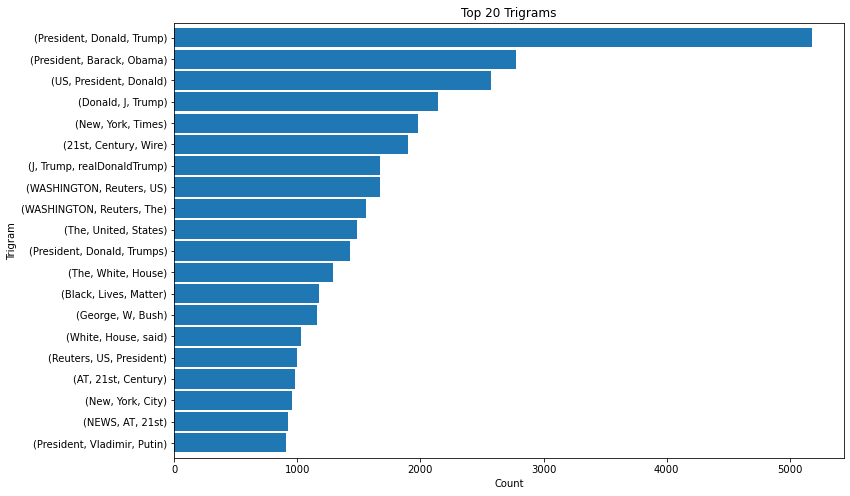

In [19]:
ISOT_trigrams_series.sort_values().plot.barh(width=.9, figsize=(12, 8))
plt.title('Top 20 Trigrams')
plt.ylabel('Trigram')
plt.xlabel('Count')

### 2.1.2 Generating Word Clouds

In [20]:
from wordcloud import WordCloud

def gen_wordcloud(dataframe):
    text = ''
    for news in dataframe.text.values:
        text += f" {news}"
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
    fig = plt.figure(
        figsize = (40,30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    del text

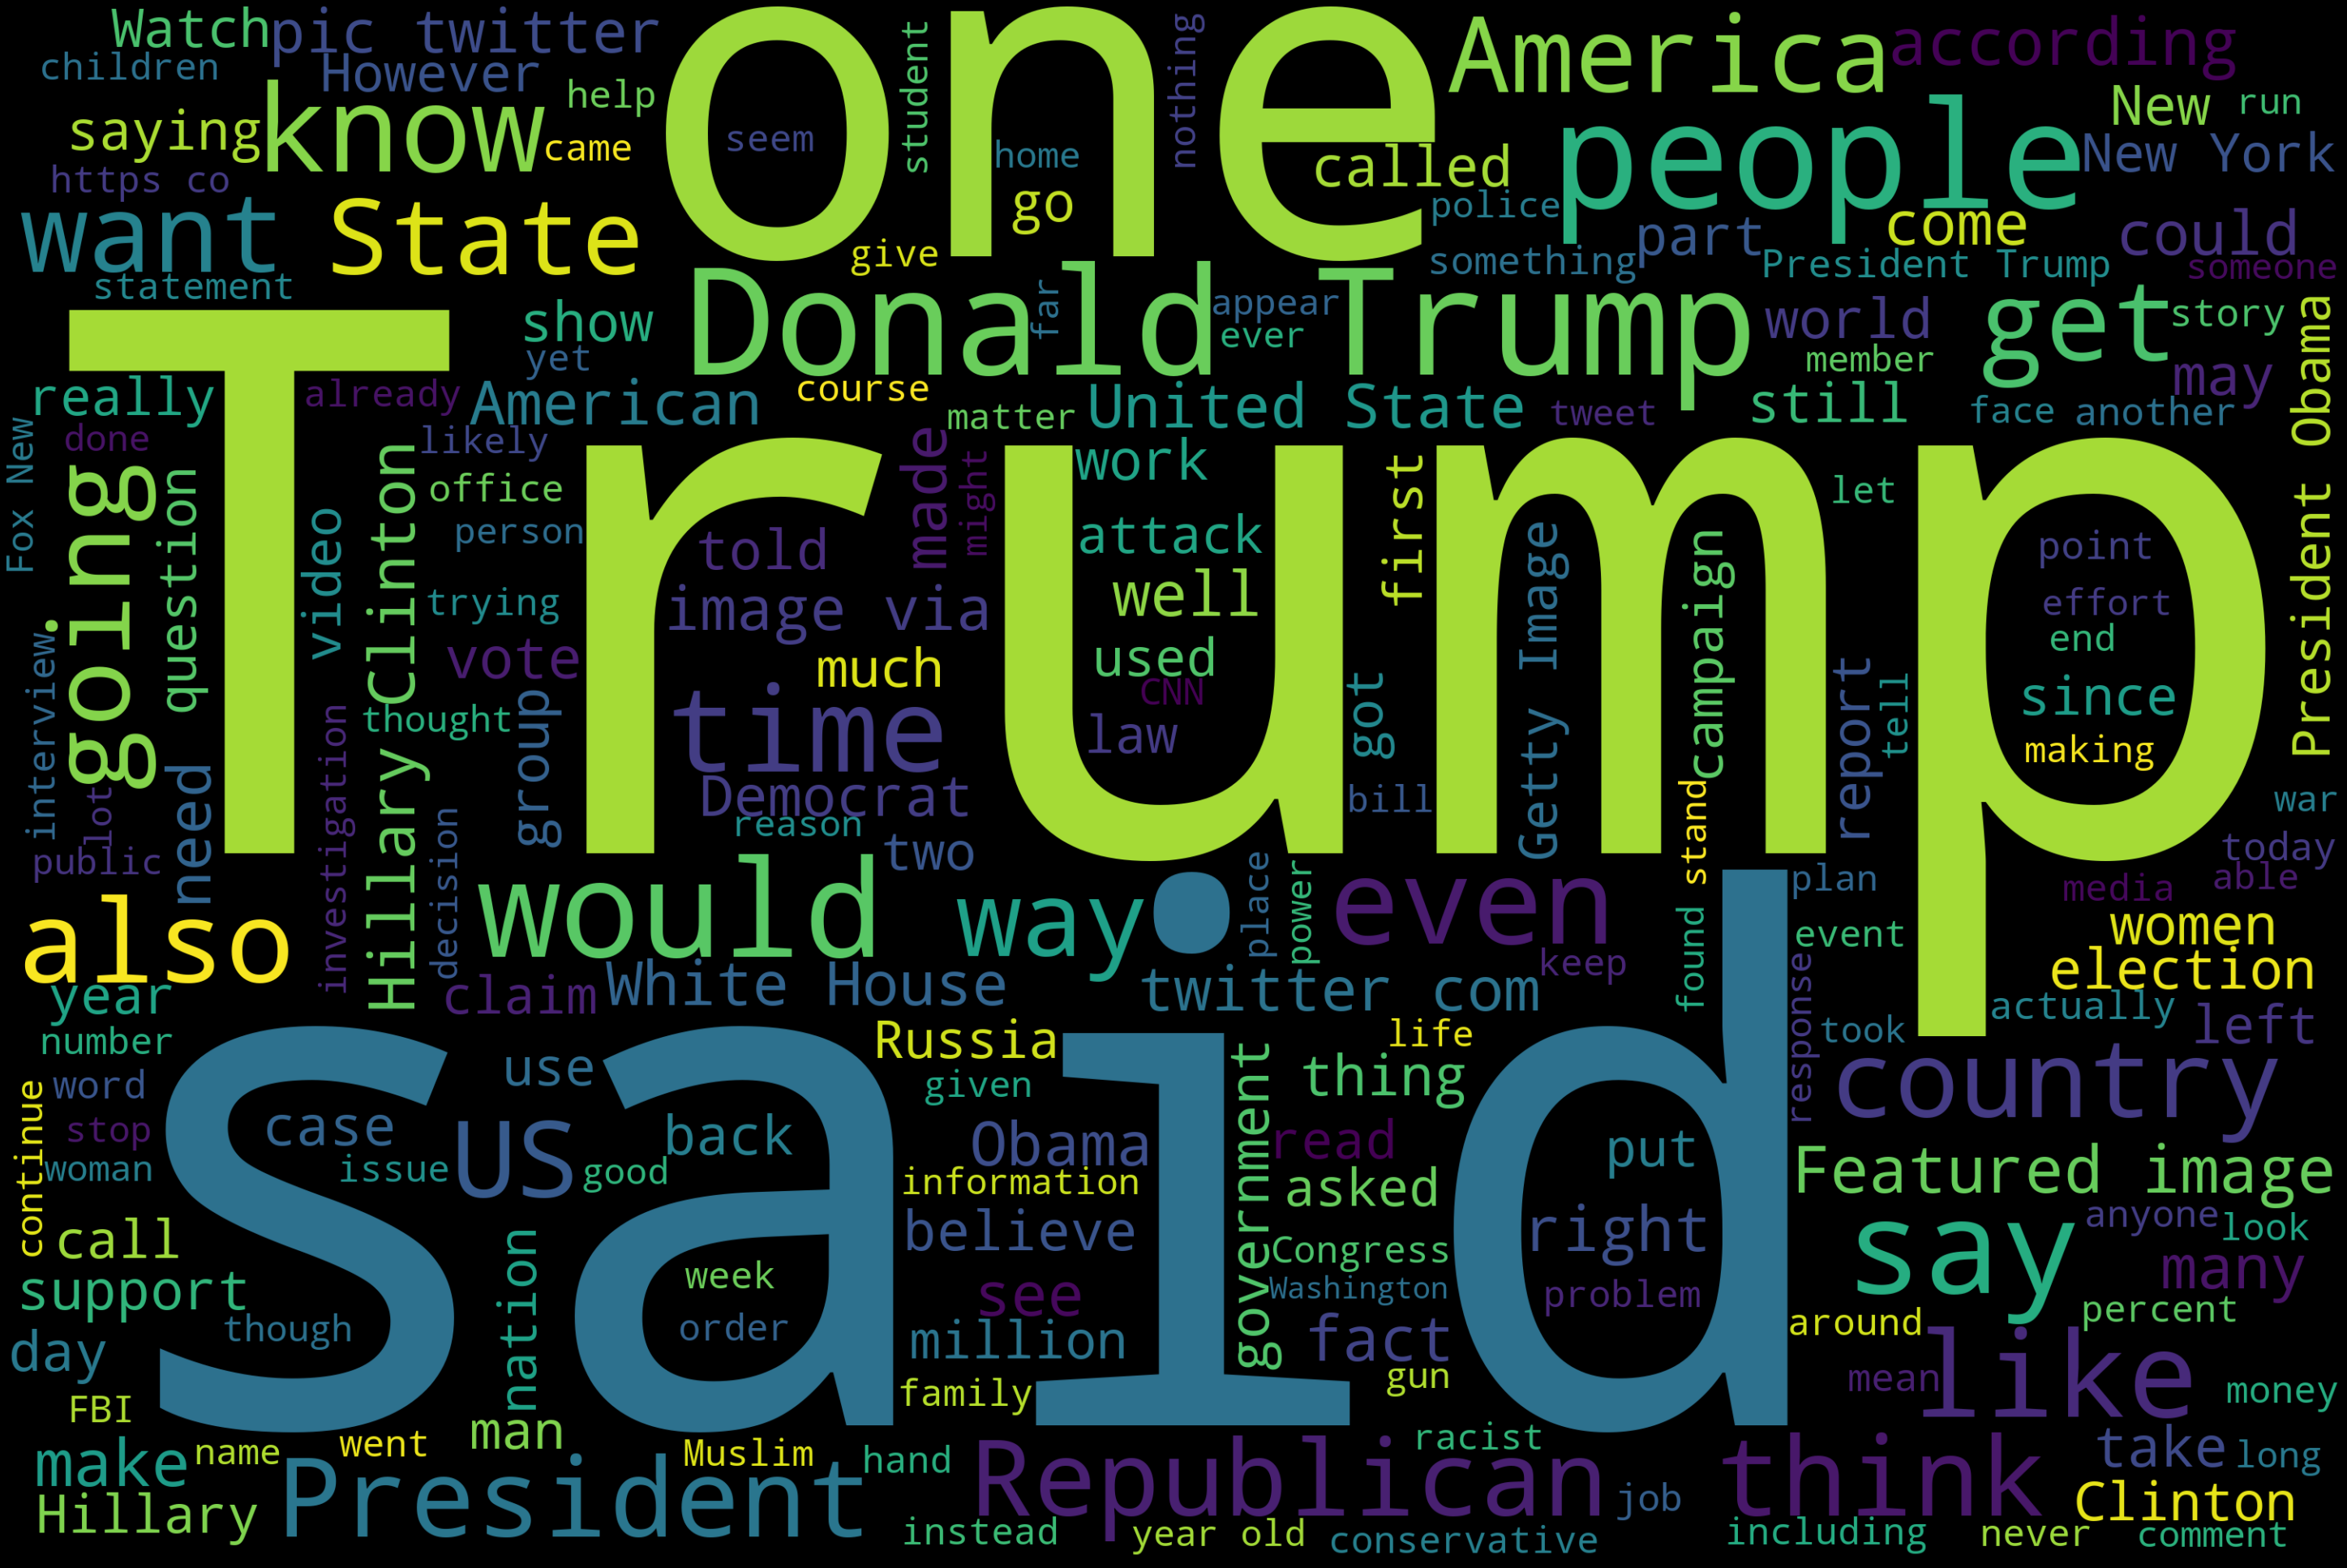

Wall time: 2min 12s


In [21]:
%%time
gen_wordcloud(ISOT_fake)

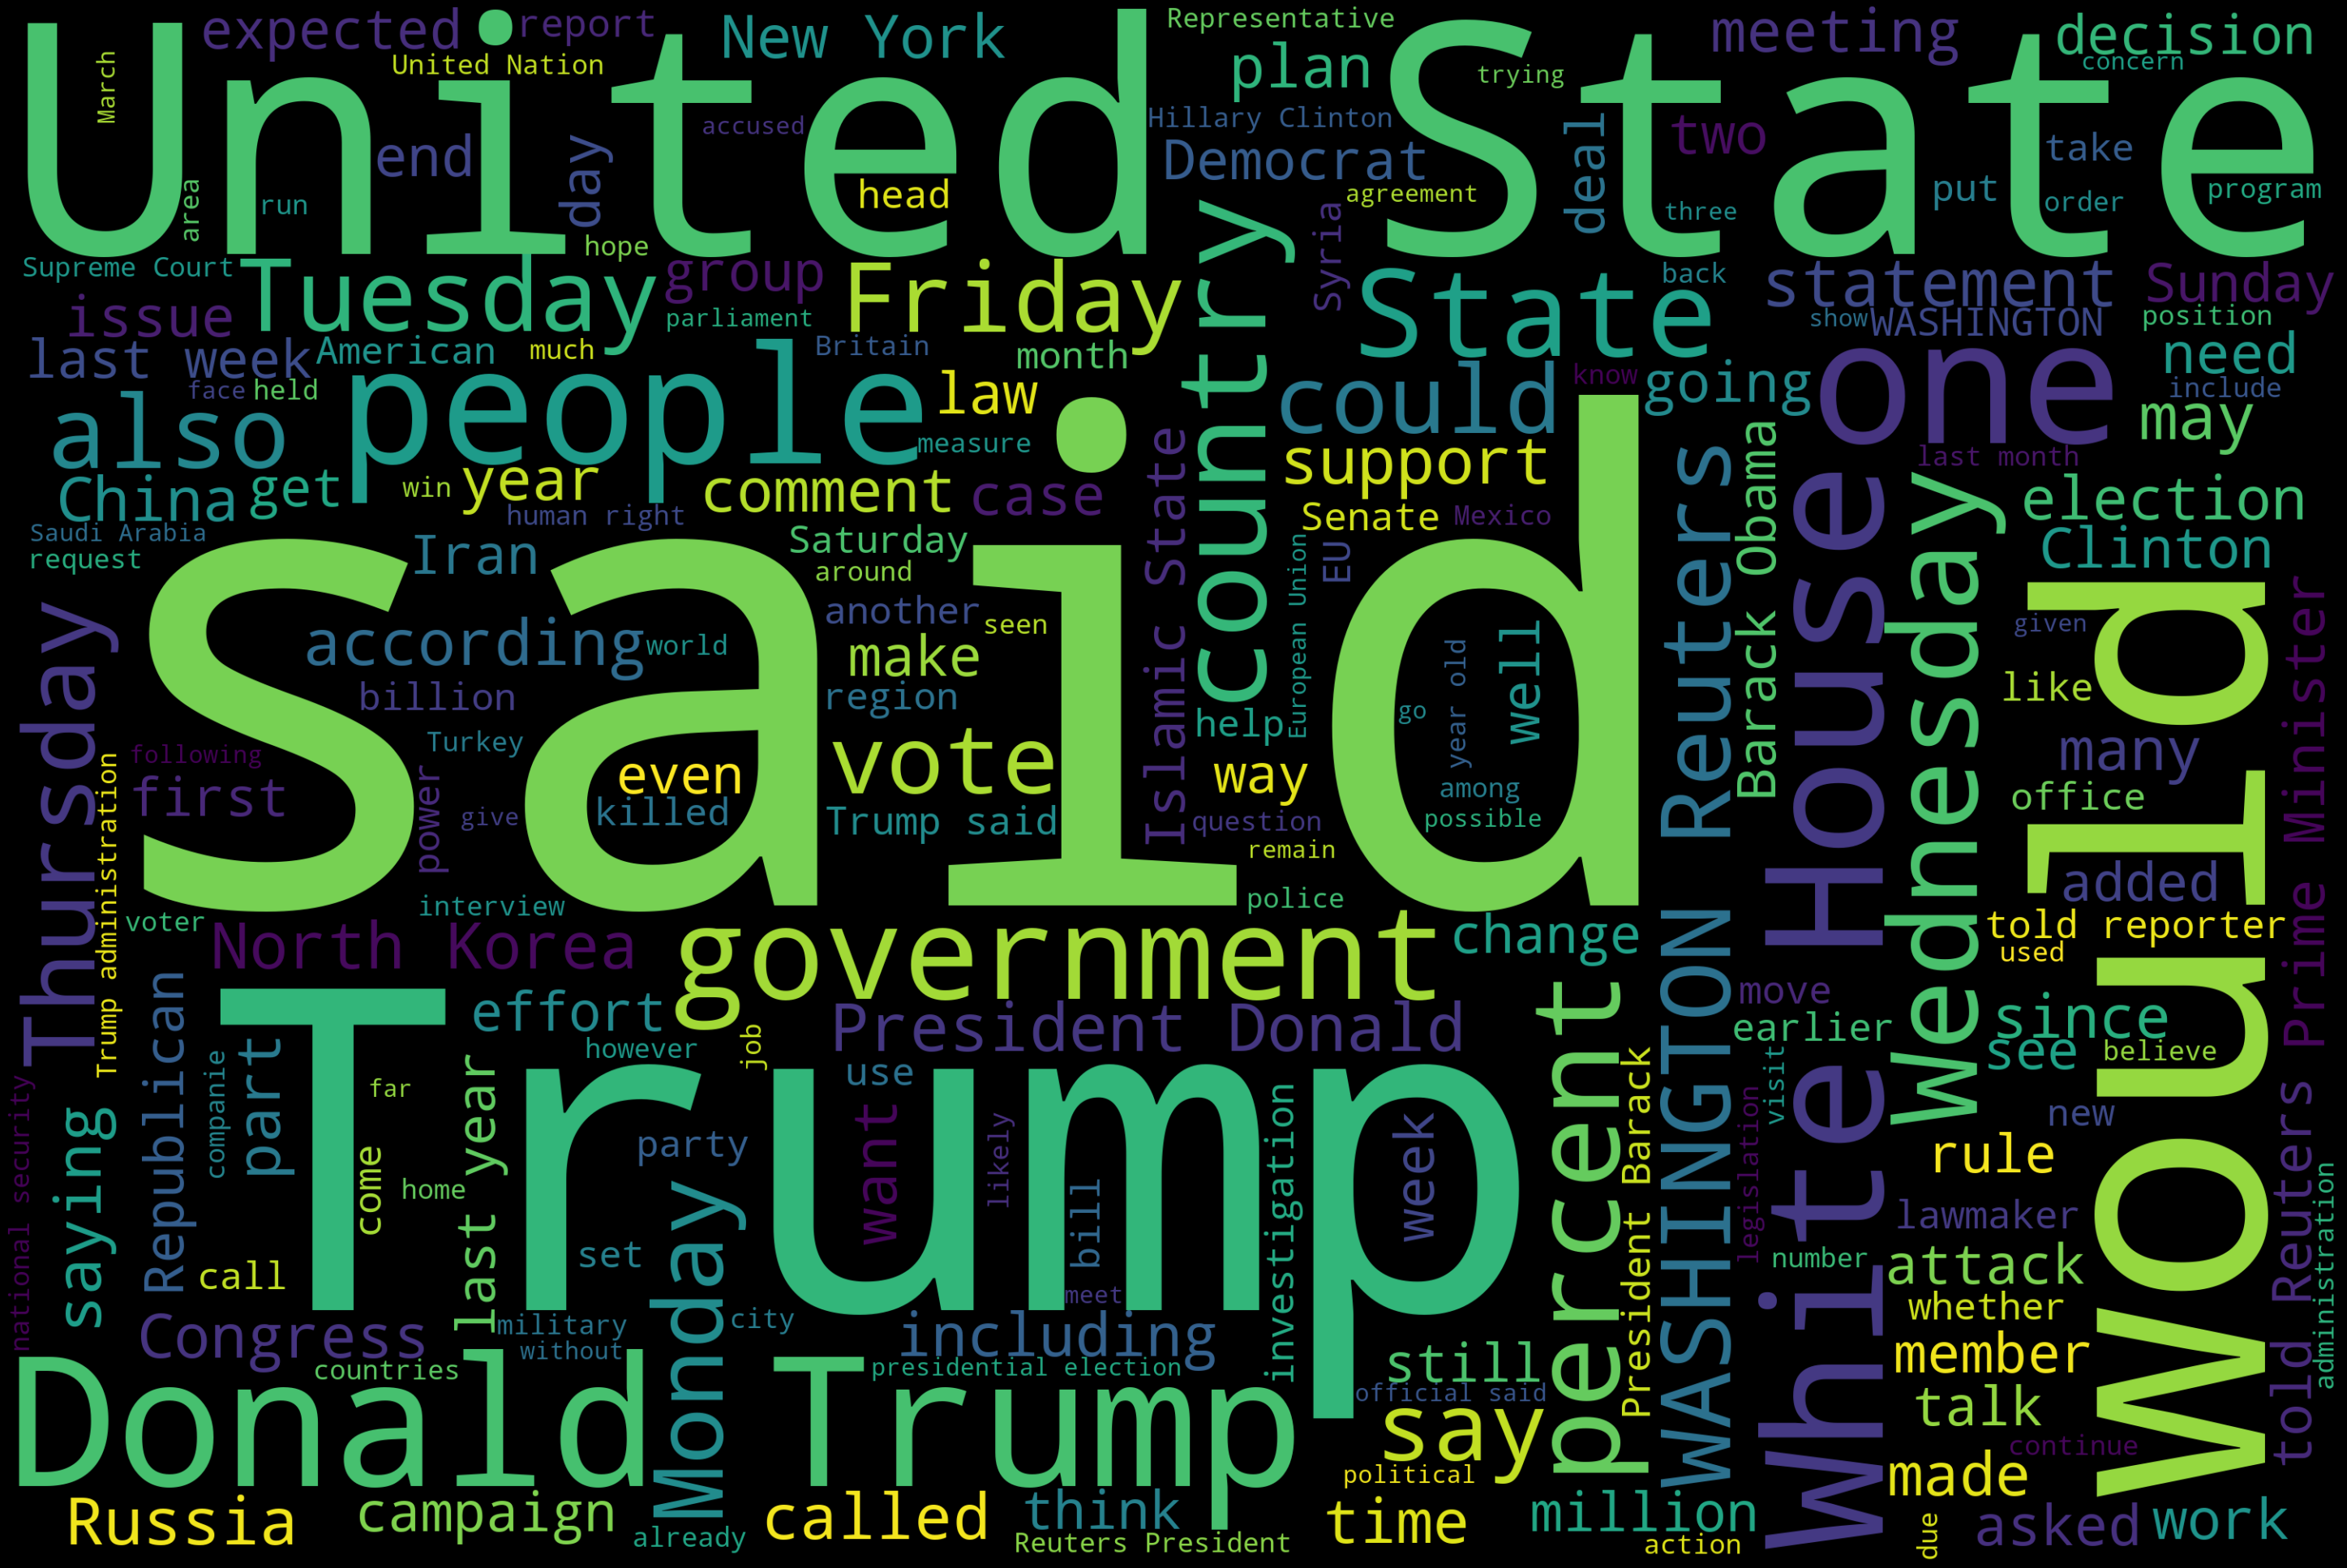

Wall time: 4min 41s


In [22]:
%%time 
gen_wordcloud(ISOT_true)

### 2.2 FNN Dataset

### 2.2.1 Analyzing News Sources

In [23]:
FNN_df.head()

text  \
0  During a campaign stop in Philadelphia, Vice P...   
1  With the growing threat of terrorism around th...   
2  BOOM! Marines Send TERRORISTS Scathing Message...   
3  Lester Holt, who anchors "NBC Nightly News," w...   
4  Story highlights A final lab test of ISIS weap...   

                     source  label  
0            http://abcn.ws      0  
1       http://usherald.com      1  
2  http://rightwingnews.com      1  
3          http://politi.co      0  
4             http://cnn.it      0

In [24]:
fake_order=FNN_fake['source'].value_counts().sort_values(ascending=False).index

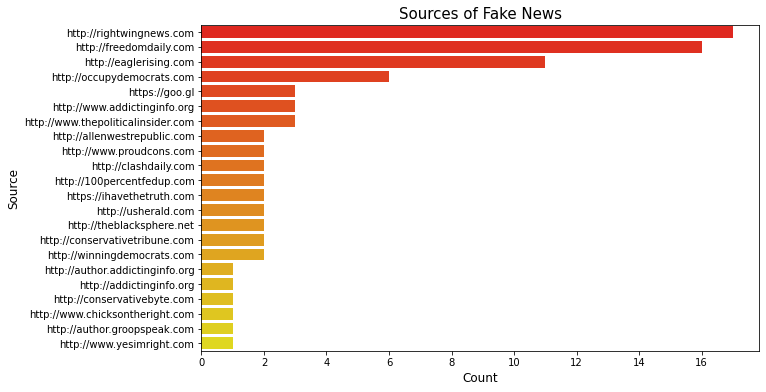

In [25]:
plt.figure(figsize=(10,6))
sns.countplot(y='source', data=FNN_fake,order = fake_order,palette='autumn')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Fake News',fontsize=15)
plt.show()

In [26]:
true_order=FNN_true['source'].value_counts().sort_values(ascending=False).index

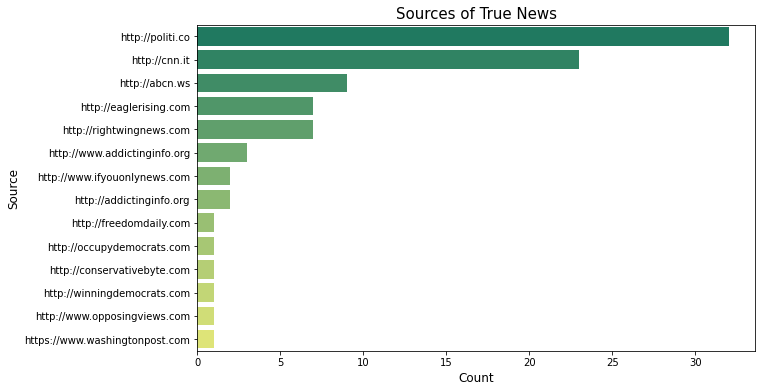

In [27]:
plt.figure(figsize=(10,6))
sns.countplot(y='source', data=FNN_true,order = true_order,palette='summer')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of True News',fontsize=15)
plt.show()

### 2.2.2 Generating Word Clouds

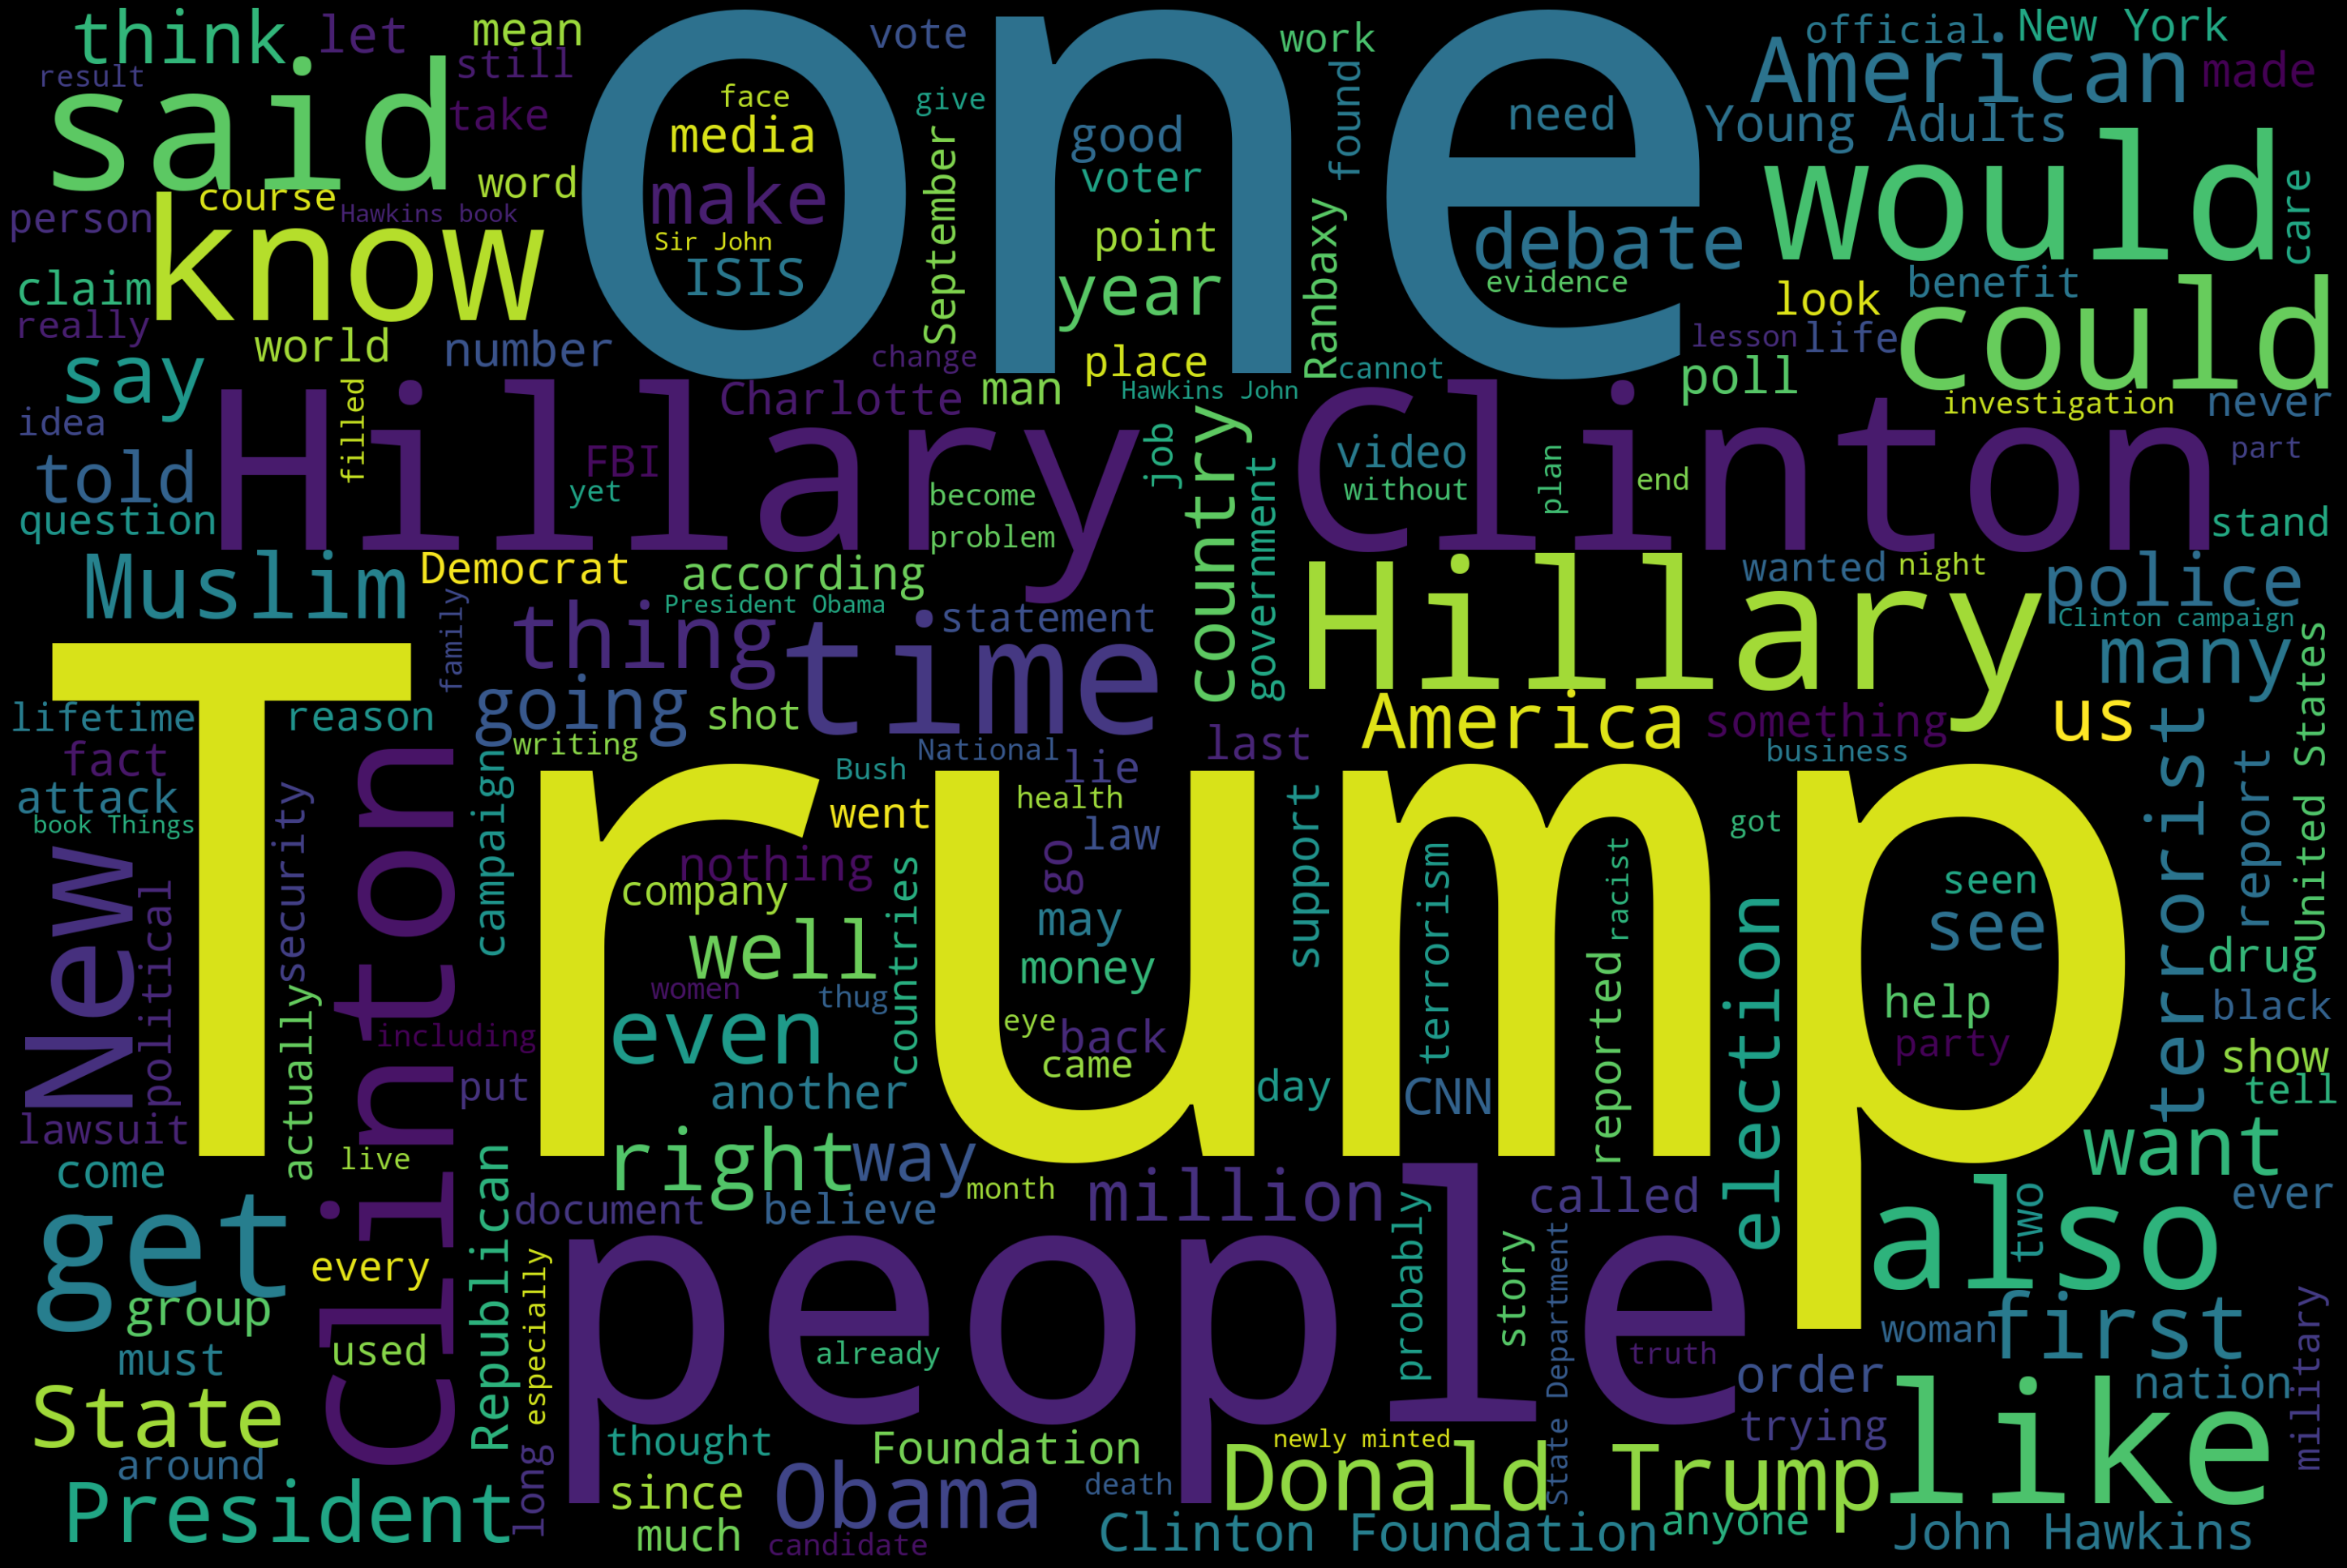

In [28]:
gen_wordcloud(FNN_fake)

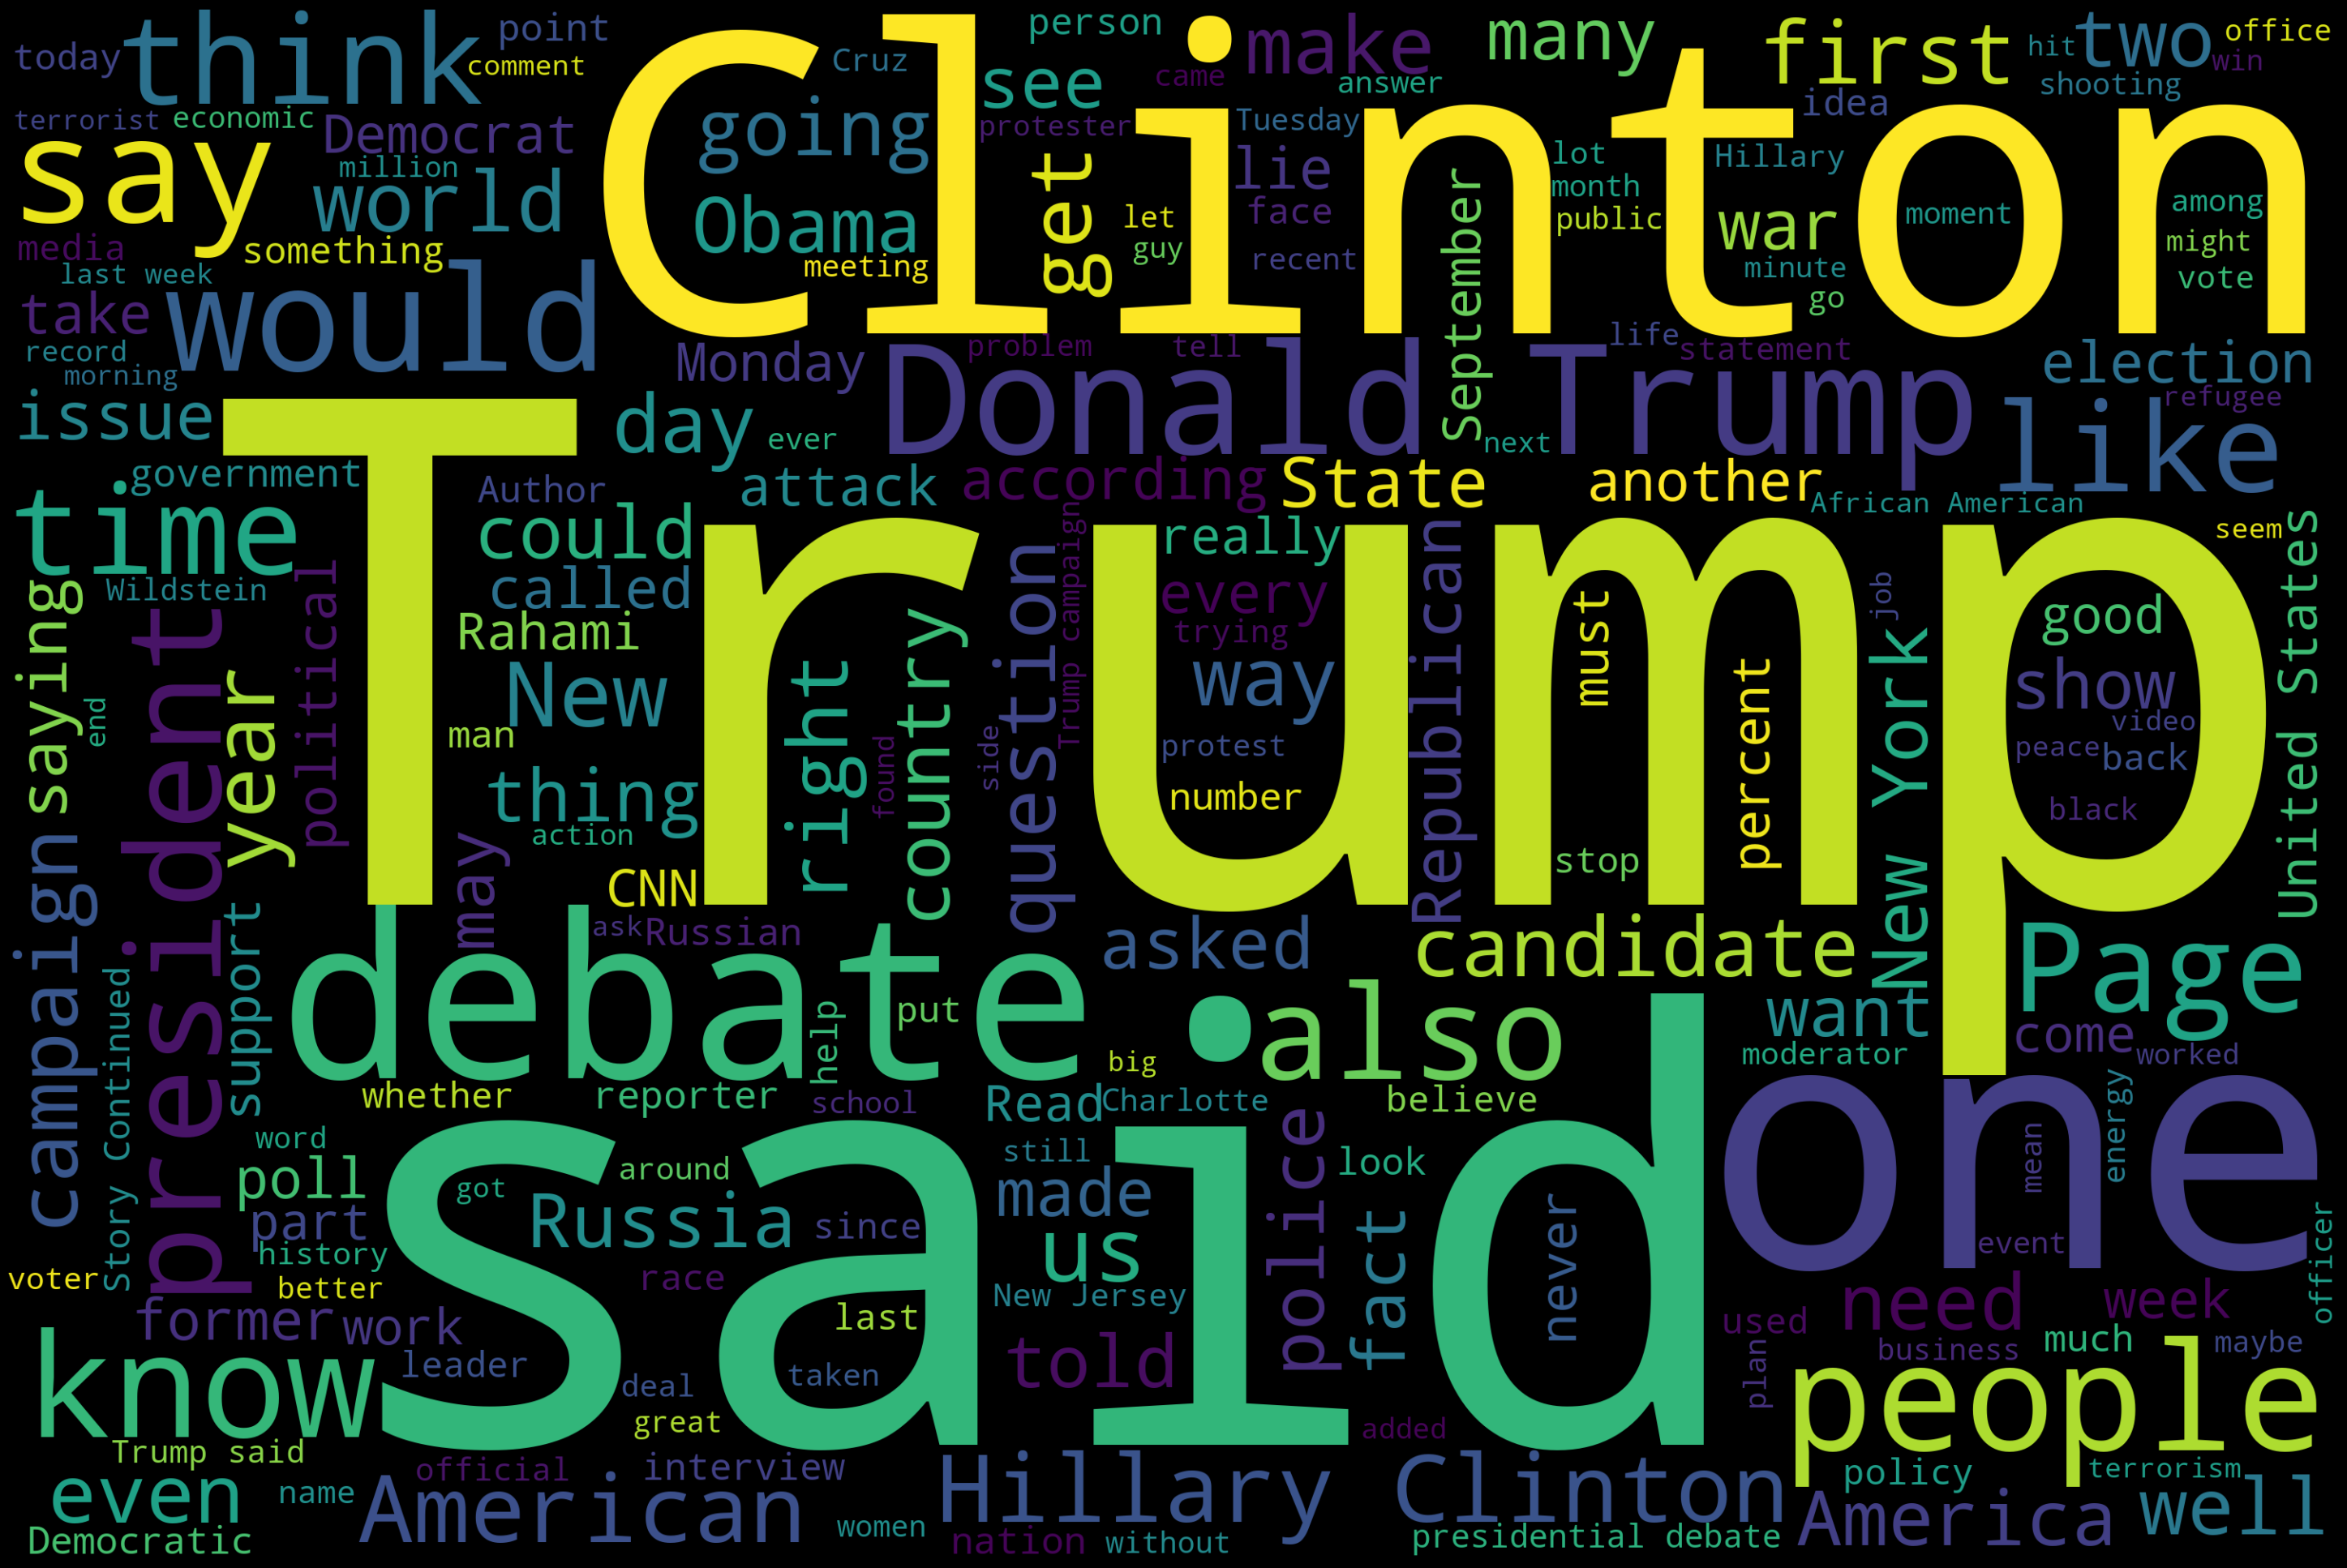

In [29]:
gen_wordcloud(FNN_true)

## 3. Dataset Preprocessing

In [30]:

'''

Preprocessing steps include: 
1. Removing punctuation
2. Converting to lowercase
3. Removing stopwords
4. Tokenization
5. Lemmatizing word tokens

'''

def process_text (text):
    
    stopwords = set(nltk.corpus.stopwords.words('english'))
    lemm = WordNetLemmatizer()

    # Removing Punctuationm
    process_text = "".join ([char for char in text if char not in string.punctuation])
    # Tokenizing Text and converting to lowercase
    process_text = re.split('\W+', text.lower())
    # Removing stopwords
    process_text = [word for word in process_text if word not in stopwords]
    # Lemmatization
    process_text = " ".join ([lemm.lemmatize(i,'v') for i in process_text])
    return process_text

def tokenize_text(text):
    
    stopwords = set(nltk.corpus.stopwords.words('english'))
    lemm = WordNetLemmatizer()
    
    # Removing Punctuationm
    tokenize_text = "".join ([char for char in text if char not in string.punctuation])
    # Tokenizing Text and converting to lowercase
    tokenize_text = re.split('\W+', text.lower())
    # Removing stopwords
    #tokenize_text = [word for word in tokenize_text if word not in stopwords]
    join_stopword = (" ".join(tokenize_text))
    return join_stopword

In [31]:
ISOT_df['cleaned'] = ISOT_df['text'].apply(lambda x: process_text(x))
ISOT_df['tokenized'] = ISOT_df['text'].apply(lambda x: tokenize_text(x))

# Rearranging columns
column_names = ["text","tokenized","cleaned","label"]
ISOT_df = ISOT_df.reindex(columns=column_names)

ISOT_df.head()

text  \
0  The city s first transgender police officer wa...   
1   In response to the establishment media s cont...   
2  Martin Shkreli quickly gained notoriety during...   
3  We pay our senators $174,000 per year. For tha...   
4  SO YOUR HUSBAND TURNS 69 If he s Bill Clinton ...   

                                           tokenized  \
0  the city s first transgender police officer wa...   
1   in response to the establishment media s cont...   
2  martin shkreli quickly gained notoriety during...   
3  we pay our senators 174 000 per year for that ...   
4  so your husband turns 69 if he s bill clinton ...   

                                             cleaned  label  
0  city first transgender police officer keep eve...      1  
1   response establishment media contrive fake ne...      1  
2  martin shkreli quickly gain notoriety contenti...      1  
3  pay senators 174 000 per year money get every ...      1  
4  husband turn 69 bill clinton get heckle bunch ...      1

In [32]:
FNN_df['cleaned']= FNN_df['text'].apply (lambda x: process_text(x))

# Rearranging columns
column_names =  ['text','cleaned','url','label']
FNN_df = FNN_df.reindex(columns=column_names)

FNN_df.head()

text  \
0  During a campaign stop in Philadelphia, Vice P...   
1  With the growing threat of terrorism around th...   
2  BOOM! Marines Send TERRORISTS Scathing Message...   
3  Lester Holt, who anchors "NBC Nightly News," w...   
4  Story highlights A final lab test of ISIS weap...   

                                             cleaned  url  label  
0  campaign stop philadelphia vice president joe ...  NaN      0  
1  grow threat terrorism around world increase ho...  NaN      1  
2  boom marines send terrorists scathing message ...  NaN      1  
3  lester holt anchor nbc nightly news moderatorf...  NaN      0  
4  story highlight final lab test isis weapon fir...  NaN      0

## 4. Split Test/Train data

In [33]:
# The ISOT dataset shall then be split into train/test data using sklearn 
# Manipulated variable = 'cleaned' column
# Responsiding variable = 'label' ccolumn

from sklearn.model_selection import train_test_split

x = ISOT_df.cleaned 
y = ISOT_df.label

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(35918,) (8980,) (35918,) (8980,)


## 5. Feature Generation


### 5.1 TF_IDF

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vect = CountVectorizer()
x_trainCounts = vect.fit_transform(x_train)

In [35]:
tfidf_transformer = TfidfTransformer()
x_trainTFIDF = tfidf_transformer.fit_transform(x_trainCounts)
x_trainTFIDF.shape

(35918, 99849)

### 5.2 POS Tags

* Example of tags are listed below: (From the NLTK Universal tagset)



| Tag | Meaning | English Examples |
| ------------- |:----------------:|:----------------:|
| ADJ | adjective | new, good, high, special, big, local |
| ADP | adposition  | on, of, at, with, by, into, under |
| ADV  | adverb | really, already, still, early, now |
| CONJ  | conjunction |  and, or, but, if, while, although  |
|  DET | determiner, article  | the, a, some, most, every, no, which  |
| NOUN | noun | noun year, home, costs, time, Africa   |
| NUM |numeral | twenty-four, fourth, 1991, 14:24  |
| PRT  |particle  |  at, on, out, over per, that, up, with   |
| PRON | pronoun |   he, their, her, its, my, I, us  |
| VERB | verb |  is, say, told, given, playing, would  |
| "." | punctuation | " . , ; !"  |
|X | other  | ersatz, esprit, dunno, gr8, univeristy  |


In [36]:
def pos_tag(text):
    postag = nltk.pos_tag(word_tokenize(text),tagset = 'universal')
    pos_list = list()
    for word in postag:
        pos_list.append(word[0] + "/" + word[1])
    
    final = ' '.join(pos_list)
    return final


In [37]:
x_trainPOS = x_train.apply(pos_tag)

In [38]:
print(x_trainPOS.head())

36335    happy/ADJ super/NOUN tuesday/NOUN result/NOUN ...
12384    please/VERB pray/NOUN victims/NOUN families/NO...
24419    portion/NOUN interview/NOUN conduct/NOUN group...
24740    washington/NOUN reuters/NOUN top/ADJ democrat/...
27039    washington/NOUN reuters/NOUN wisconsin/VERB el...
Name: cleaned, dtype: object


### 5.3 POS CountVec & TFIDF

In [39]:
vect = CountVectorizer()
x_trainPOS_Count = vect.fit_transform(x_trainPOS)
#x_testPOS_Count = vect.transform(x_testPOS)

In [40]:
tfidf_transformer = TfidfTransformer()
x_trainPOS_Tfidf = tfidf_transformer.fit_transform(x_trainPOS_Count)
#x_testPOS_Tfidf = tfidf_transformer.transform(x_testPOS_Count)
x_trainPOS_Tfidf.shape

(35918, 99852)

### 5.4 N-Grams

Fitting on the training set and transforming on the training and test set assures that:
 - given a word, the word is correctly always mapped on the same column, both in the training and test set. 

In [41]:
vect = CountVectorizer(ngram_range=(2,3))
x_trainNgram = vect.fit_transform(x_train)
vect.get_feature_names()

['00 000',
 '00 000 people',
 '00 00pm',
 '00 00pm learn',
 '00 0109',
 '00 0109 est',
 '00 0500',
 '00 0500 gmt',
 '00 0721',
 '00 0721 edt',
 '00 0800',
 '00 0800 gmt',
 '00 09',
 '00 09 occupiers',
 '00 11',
 '00 11 march',
 '00 1200',
 '00 1200 gmt',
 '00 16',
 '00 16 00',
 '00 1600',
 '00 1600 gmt',
 '00 1700',
 '00 1700 gmt',
 '00 18',
 '00 18 00',
 '00 1800',
 '00 1800 gmt',
 '00 1931',
 '00 1931 est',
 '00 201',
 '00 201 000',
 '00 22',
 '00 22 ampresident',
 '00 accord',
 '00 accord police',
 '00 add',
 '00 add trump',
 '00 address',
 '00 address real',
 '00 afternoon',
 '00 afternoon saturday',
 '00 allow',
 '00 allow civilians',
 '00 also',
 '00 also schedule',
 '00 american',
 '00 american consumers',
 '00 announcement',
 '00 announcement vp',
 '00 bill',
 '00 bill clinton',
 '00 california',
 '00 california congresswoman',
 '00 campaign',
 '00 campaign headquarter',
 '00 central',
 '00 central specific',
 '00 central time',
 '00 charity',
 '00 charity 86',
 '00 civilians',

## 6. Modelling

### 6.1 Evaluation Metrics 

Several evaluation metrices shall be used:
1. Model Score (Accuracy)
1. Precision Score
1. F1- Score 
1. Recall Score

In [42]:
## Function to plot confusion matrix using matplot
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
def get_results(cm,test,pred):
    print("Accuracy: {}%".format(round(metrics.accuracy_score(test, pred)*100,2)))
    print("Precision:", metrics.precision_score(test, pred, pos_label=0))
    print("Recall:", metrics.recall_score(test, pred))
    print("F1 Score:", metrics.f1_score(test,pred))
    print ("\n Confusion Matrix \n", cm)
    print(classification_report(test, pred))


In [46]:
from sklearn.metrics import classification_report, confusion_matrix,f1_score, precision_score, recall_score
from sklearn import metrics 

### 6.2 TFIDF

### 6.2.1 Logistic Regression

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
import itertools

Accuracy: 98.5%
Precision: 0.9813432835820896
Recall: 0.9830400678397286
F1 Score: 0.985652035285365

 Confusion Matrix 
 [[4208   55]
 [  80 4637]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4263
           1       0.99      0.98      0.99      4717

    accuracy                           0.98      8980
   macro avg       0.98      0.99      0.98      8980
weighted avg       0.98      0.98      0.98      8980

Confusion matrix, without normalization


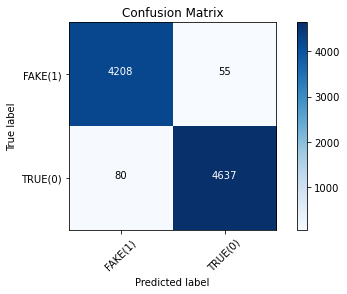

In [48]:
TFIDF_LRPipeline = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', LogisticRegression())])

TFIDF_LRPipeline.fit(x_train, y_train)
yPredict = TFIDF_LRPipeline.predict(x_test)


# Evaluation Metrics
cm = confusion_matrix (y_test, yPredict)
get_results(cm,y_test,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 6.2.2. SVM

Accuracy: 99.42%
Precision: 0.9922843114332476
Recall: 0.9930040279838881
F1 Score: 0.9944798301486198

 Confusion Matrix 
 [[4244   19]
 [  33 4684]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4263
           1       1.00      0.99      0.99      4717

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion matrix, without normalization


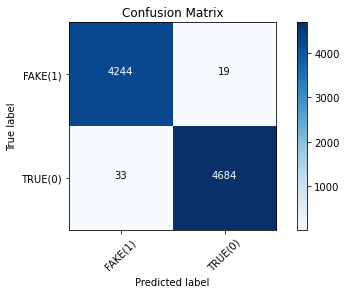

In [50]:
from sklearn.svm import SVC, LinearSVC

TFIDF_SVCPipeline = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', LinearSVC())])

TFIDF_SVCPipeline.fit(x_train, y_train)
yPredict = TFIDF_SVCPipeline.predict(x_test)

cm = confusion_matrix (y_test, yPredict)
get_results(cm,y_test,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 6.2.3 NB

Accuracy: 93.07%
Precision: 0.9306837000236574
Recall: 0.9378842484630061
F1 Score: 0.9343189017951425

 Confusion Matrix 
 [[3934  329]
 [ 293 4424]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      4263
           1       0.93      0.94      0.93      4717

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980

Confusion matrix, without normalization


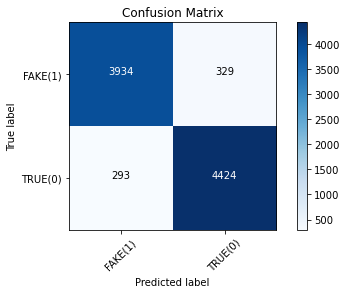

In [51]:
from sklearn.naive_bayes import MultinomialNB

TFIDF_NBPipeline = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('clf', MultinomialNB())])

TFIDF_NBPipeline.fit(x_train, y_train)
yPredict = TFIDF_NBPipeline.predict(x_test)

cm = confusion_matrix (y_test, yPredict)
get_results(cm,y_test,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

## 6.3 Ngrams

### 6.3.1 Logistic Regression

Accuracy: 98.14%
Precision: 0.9740740740740741
Recall: 0.97625609497562
F1 Score: 0.9821904660339127

 Confusion Matrix 
 [[4208   55]
 [ 112 4605]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      4263
           1       0.99      0.98      0.98      4717

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980

Confusion matrix, without normalization


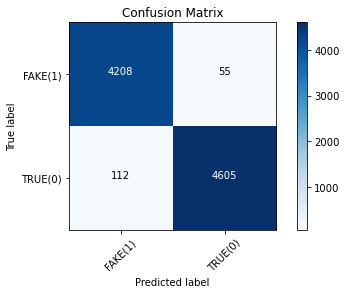

In [52]:
NGRAM_LRPipeline = Pipeline([('ngramvect', vect),
                 ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())])

NGRAM_LRPipeline.fit(x_train, y_train)

yPredict = NGRAM_LRPipeline.predict(x_test)


cm = confusion_matrix (y_test, yPredict)
get_results(cm,y_test,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 6.3.2 SVM

Accuracy: 98.76%
Precision: 0.9792243767313019
Recall: 0.9809200763196947
F1 Score: 0.988147357180993

 Confusion Matrix 
 [[4242   21]
 [  90 4627]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4263
           1       1.00      0.98      0.99      4717

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion matrix, without normalization


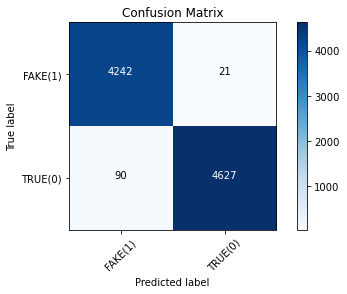

In [53]:
NGRAM_SVMPipeline = Pipeline([('vect', CountVectorizer(ngram_range=(2,3))),
                 ('tfidf', TfidfTransformer()),
                 ('clf', LinearSVC())])

NGRAM_SVMPipeline.fit(x_train, y_train)
yPredict = NGRAM_SVMPipeline.predict(x_test)


cm = confusion_matrix (y_test, yPredict)
get_results(cm,y_test,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 6.3.3 NB

Accuracy: 97.57%
Precision: 0.9652634000460087
Recall: 0.9679881280474878
F1 Score: 0.9766844919786095

 Confusion Matrix 
 [[4196   67]
 [ 151 4566]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      4263
           1       0.99      0.97      0.98      4717

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980

Confusion matrix, without normalization


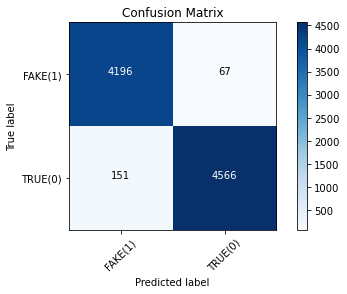

In [54]:
NGRAM_NBPipeline = Pipeline([('vect', CountVectorizer(ngram_range=(2,3) )),
                 ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

NGRAM_NBPipeline.fit(x_train,y_train)
yPredict = NGRAM_NBPipeline.predict(x_test)


cm = confusion_matrix (y_test, yPredict)
get_results(cm,y_test,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

## 6.4 POS Tags

### 6.4.1 Logistic Regression

Accuracy: 99.38%
Precision: 0.9877115696730814
Recall: 0.9887640449438202
F1 Score: 0.9940323955669225

 Confusion Matrix 
 [[4260    3]
 [  53 4664]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4263
           1       1.00      0.99      0.99      4717

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion matrix, without normalization


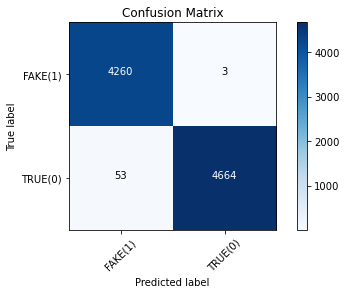

In [55]:
POS_LRPipeline = Pipeline([('vect', CountVectorizer()),
                 ('clf', LogisticRegression(max_iter=3000))])

POS_LRPipeline.fit(x_trainPOS,y_train)
yPredict = POS_LRPipeline.predict(x_test)


cm = confusion_matrix (y_test, yPredict)
get_results(cm,y_test,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 6.4.2 SVM

Accuracy: 99.28%
Precision: 0.9858796296296296
Recall: 0.9870680517277931
F1 Score: 0.9930681454623014

 Confusion Matrix 
 [[4259    4]
 [  61 4656]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4263
           1       1.00      0.99      0.99      4717

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion matrix, without normalization


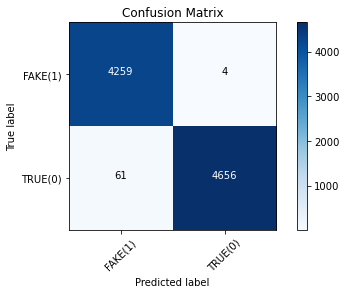

In [82]:
POS_SVMPipeline = Pipeline([('vect', CountVectorizer()),
                 ('clf', LinearSVC(max_iter = 100000 ))])

POS_SVMPipeline.fit(x_trainPOS,y_train)
yPredict = POS_SVMPipeline.predict(x_test)


cm = confusion_matrix (y_test, yPredict)
get_results(cm,y_test,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 6.4.3 NB

Accuracy: 94.65%
Precision: 0.9414235705950992
Recall: 0.9467882128471486
F1 Score: 0.9490012749681258

 Confusion Matrix 
 [[4034  229]
 [ 251 4466]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      4263
           1       0.95      0.95      0.95      4717

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980

Confusion matrix, without normalization


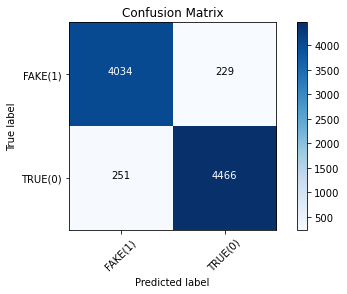

In [57]:
POS_NBPipeline = Pipeline([('vect', CountVectorizer()),
                 ('clf', MultinomialNB())])

POS_NBPipeline.fit(x_trainPOS,y_train)
yPredict = POS_NBPipeline.predict(x_test)


cm = confusion_matrix (y_test, yPredict)
get_results(cm,y_test,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

## 7. Model Validation

In [78]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

folds = KFold(n_splits= 5)

In [79]:
def cv_score(model,x,y,):
    scores = cross_val_score(model,x,y, cv = folds, scoring = 'accuracy') # cv (kfolds) = 5
    print ("Mean score : {0:.3f}".format (np.mean(scores)))

In [83]:
%%time
print ("Cross validation with kfold = 5")
print ("TFIDF")
cv_score(TFIDF_LRPipeline,x_train,y_train)
cv_score(TFIDF_SVCPipeline,x_train,y_train)
cv_score(TFIDF_NBPipeline,x_train,y_train)
print("\nNgram")
cv_score(NGRAM_LRPipeline,x_train,y_train)
cv_score(NGRAM_SVMPipeline,x_train,y_train)
cv_score(NGRAM_NBPipeline,x_train,y_train)
print("\nPOS Tag")
cv_score(POS_LRPipeline,x_train,y_train)
cv_score(POS_SVMPipeline,x_train,y_train)
cv_score(POS_NBPipeline,x_train,y_train)

Cross validation with kfold = 5
TFIDF
Mean score : 0.985
Mean score : 0.994
Mean score : 0.935

Ngram
Mean score : 0.982
Mean score : 0.987
Mean score : 0.975

POS Tag
Mean score : 0.996
Mean score : 0.996
Mean score : 0.952
Wall time: 21min 8s


### 8.1 FNN Dataset

In [58]:
FNN_TestFeatures = FNN_df['cleaned']
FNN_TestLabels =FNN_df['label']

### 8.1.1 Logistic Regression

Accuracy: 53.3%
Precision: 0.875
Recall: 0.989010989010989
F1 Score: 0.679245283018868

 Confusion Matrix 
 [[ 7 84]
 [ 1 90]]
              precision    recall  f1-score   support

           0       0.88      0.08      0.14        91
           1       0.52      0.99      0.68        91

    accuracy                           0.53       182
   macro avg       0.70      0.53      0.41       182
weighted avg       0.70      0.53      0.41       182

Confusion matrix, without normalization


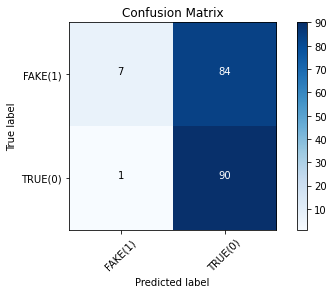

In [59]:
model = TFIDF_LRPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
get_results(cm,FNN_TestLabels,pred)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.1.2 SVM

Accuracy: 53.3%
Precision: 0.875
Recall: 0.989010989010989
F1 Score: 0.679245283018868

 Confusion Matrix 
 [[ 7 84]
 [ 1 90]]
              precision    recall  f1-score   support

           0       0.88      0.08      0.14        91
           1       0.52      0.99      0.68        91

    accuracy                           0.53       182
   macro avg       0.70      0.53      0.41       182
weighted avg       0.70      0.53      0.41       182

Confusion matrix, without normalization


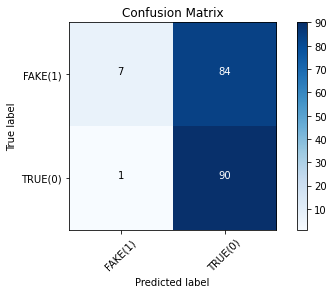

In [60]:
model = TFIDF_SVCPipeline
yPredict = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
get_results(cm,FNN_TestLabels,pred)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.1.3 NB

Accuracy: 52.75%
Precision: 0.6470588235294118
Recall: 0.9340659340659341
F1 Score: 0.6640625

 Confusion Matrix 
 [[11 80]
 [ 6 85]]
              precision    recall  f1-score   support

           0       0.65      0.12      0.20        91
           1       0.52      0.93      0.66        91

    accuracy                           0.53       182
   macro avg       0.58      0.53      0.43       182
weighted avg       0.58      0.53      0.43       182

Confusion matrix, without normalization


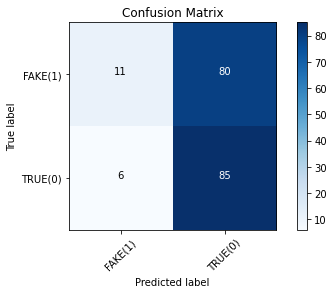

In [61]:
model = TFIDF_NBPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
get_results(cm,FNN_TestLabels,pred)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.2 Ngrams

### 8.2.1 Logistic Regression

Accuracy: 55.49%
Precision: 0.8125
Recall: 0.967032967032967
F1 Score: 0.6848249027237354

 Confusion Matrix 
 [[13 78]
 [ 3 88]]
              precision    recall  f1-score   support

           0       0.81      0.14      0.24        91
           1       0.53      0.97      0.68        91

    accuracy                           0.55       182
   macro avg       0.67      0.55      0.46       182
weighted avg       0.67      0.55      0.46       182

Confusion matrix, without normalization


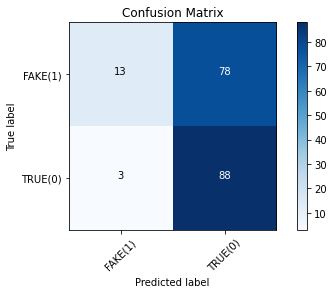

In [62]:
model = NGRAM_LRPipeline

pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
get_results(cm,FNN_TestLabels,pred)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.2.2 SVM

Accuracy: 56.59%
Precision: 0.9285714285714286
Recall: 0.989010989010989
F1 Score: 0.694980694980695

 Confusion Matrix 
 [[13 78]
 [ 1 90]]
              precision    recall  f1-score   support

           0       0.93      0.14      0.25        91
           1       0.54      0.99      0.69        91

    accuracy                           0.57       182
   macro avg       0.73      0.57      0.47       182
weighted avg       0.73      0.57      0.47       182

Confusion matrix, without normalization


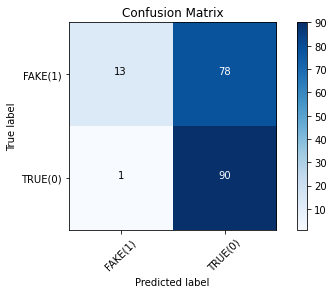

In [63]:
model = NGRAM_SVMPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
get_results(cm,FNN_TestLabels,pred)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.2.3 NB

Accuracy: 54.95%
Precision: 0.7368421052631579
Recall: 0.945054945054945
F1 Score: 0.6771653543307087

 Confusion Matrix 
 [[14 77]
 [ 5 86]]
              precision    recall  f1-score   support

           0       0.74      0.15      0.25        91
           1       0.53      0.95      0.68        91

    accuracy                           0.55       182
   macro avg       0.63      0.55      0.47       182
weighted avg       0.63      0.55      0.47       182

Confusion matrix, without normalization


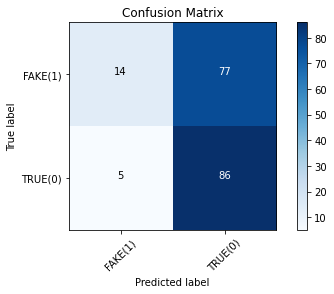

In [64]:
model = NGRAM_NBPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
get_results(cm,FNN_TestLabels,pred)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

## 8.3 POS Tags

### 8.3.1 Logistic Regression

Accuracy: 52.75%
Precision: 1.0
Recall: 1.0
F1 Score: 0.6791044776119404

 Confusion Matrix 
 [[ 5 86]
 [ 0 91]]
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        91
           1       0.51      1.00      0.68        91

    accuracy                           0.53       182
   macro avg       0.76      0.53      0.39       182
weighted avg       0.76      0.53      0.39       182

Confusion matrix, without normalization


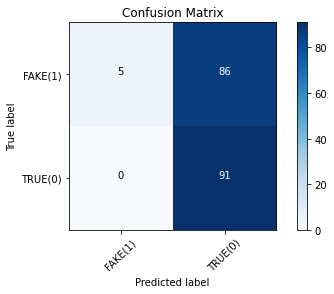

In [65]:
model = POS_LRPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
get_results(cm,FNN_TestLabels,pred)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.3.2 SVM

Accuracy: 51.65%
Precision: 1.0
Recall: 1.0
F1 Score: 0.674074074074074

 Confusion Matrix 
 [[ 3 88]
 [ 0 91]]
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        91
           1       0.51      1.00      0.67        91

    accuracy                           0.52       182
   macro avg       0.75      0.52      0.37       182
weighted avg       0.75      0.52      0.37       182

Confusion matrix, without normalization


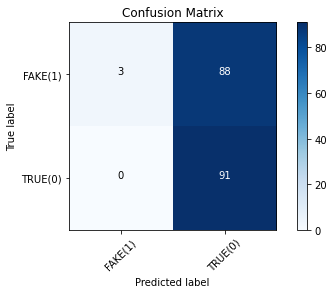

In [66]:
model = POS_SVMPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
get_results(cm,FNN_TestLabels,pred)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 8.3.3 NB

Accuracy: 53.85%
Precision: 0.7692307692307693
Recall: 0.967032967032967
F1 Score: 0.6769230769230768

 Confusion Matrix 
 [[10 81]
 [ 3 88]]
              precision    recall  f1-score   support

           0       0.77      0.11      0.19        91
           1       0.52      0.97      0.68        91

    accuracy                           0.54       182
   macro avg       0.64      0.54      0.43       182
weighted avg       0.64      0.54      0.43       182

Confusion matrix, without normalization


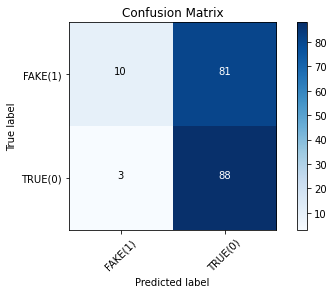

In [67]:
model = POS_NBPipeline
pred = model.predict(FNN_TestFeatures)

cm = confusion_matrix (FNN_TestLabels, pred)
get_results(cm,FNN_TestLabels,pred)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

## 9. Combining Features

In [68]:
x = ISOT_df.tokenized
y = ISOT_df.label

x2_train,x2_test,y2_train,y2_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(35918,) (8980,) (35918,) (8980,)


## 9.1 Lemm + CountWord

### 9.1.1 Logitisc Regression

Accuracy: 99.5%
Precision: 0.9934487599438465
Recall: 0.994064023743905
F1 Score: 0.9952244508118433

 Confusion Matrix 
 [[4246   17]
 [  28 4689]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4263
           1       1.00      0.99      1.00      4717

    accuracy                           0.99      8980
   macro avg       0.99      1.00      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion matrix, without normalization


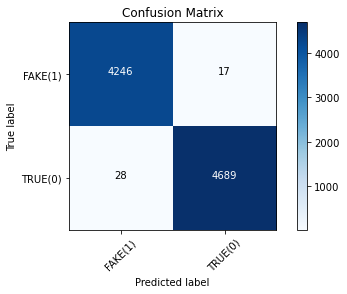

In [69]:
LRmodel = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(max_iter = 1000))
])
                          
LRmodel.fit(x2_train, y2_train)
yPredict = LRmodel.predict(x2_test)

# Evaluation Metrics
cm = confusion_matrix (y2_test, yPredict)
get_results(cm,y2_test,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 9.1.2 SVM

Accuracy: 99.45%
Precision: 0.9925198690977092
Recall: 0.9932160271358914
F1 Score: 0.9947977492302792

 Confusion Matrix 
 [[4246   17]
 [  32 4685]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4263
           1       1.00      0.99      0.99      4717

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

Confusion matrix, without normalization


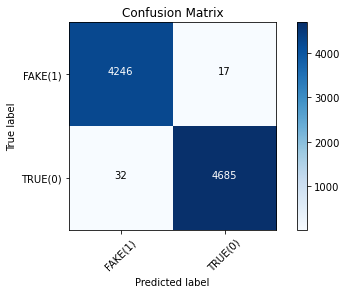

In [70]:
SVMModel = Pipeline([('vect', CountVectorizer()),
                 ('clf', LinearSVC(max_iter = 60000))])
               
SVMModel.fit(x2_train, y2_train)
yPredict = SVMModel.predict(x2_test)

cm = confusion_matrix (y2_test, yPredict)
get_results(cm,y2_test,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

Accuracy: 95.04%
Precision: 0.9431290622098422
Recall: 0.948060207759169
F1 Score: 0.9526041111939504

 Confusion Matrix 
 [[4063  200]
 [ 245 4472]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      4263
           1       0.96      0.95      0.95      4717

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980

Confusion matrix, without normalization


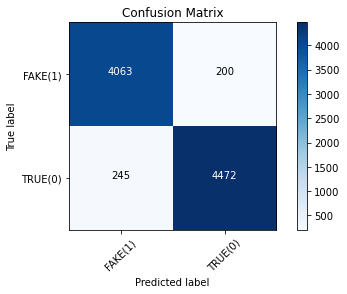

In [71]:
NBModel = Pipeline([('vect', CountVectorizer()),
                 ('clf', MultinomialNB())])

NBModel.fit(x2_train, y2_train)
yPredict = NBModel.predict(x2_test)

cm = confusion_matrix (y2_test, yPredict)
get_results(cm,y2_test,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

## 9.2 FNN Dataset

### 9.2.1 Logitisc Regression

Accuracy: 49.45%
Precision: 0.0
Recall: 0.989010989010989
F1 Score: 0.6617647058823529

 Confusion Matrix 
 [[ 0 91]
 [ 1 90]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.50      0.99      0.66        91

    accuracy                           0.49       182
   macro avg       0.25      0.49      0.33       182
weighted avg       0.25      0.49      0.33       182

Confusion matrix, without normalization


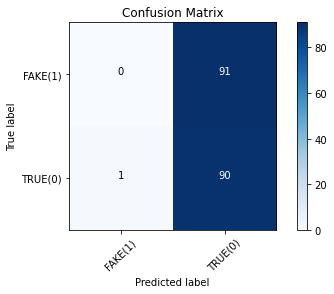

In [73]:
model = LRmodel
yPredict = model.predict(FNN_TestFeatures)

# Evaluation Metrics
cm = confusion_matrix (FNN_TestLabels, yPredict)
get_results(cm,FNN_TestLabels,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 9.2.2 SVM

Accuracy: 50.0%
Precision: 0.0
Recall: 1.0
F1 Score: 0.6666666666666666

 Confusion Matrix 
 [[ 0 91]
 [ 0 91]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        91
           1       0.50      1.00      0.67        91

    accuracy                           0.50       182
   macro avg       0.25      0.50      0.33       182
weighted avg       0.25      0.50      0.33       182

Confusion matrix, without normalization


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


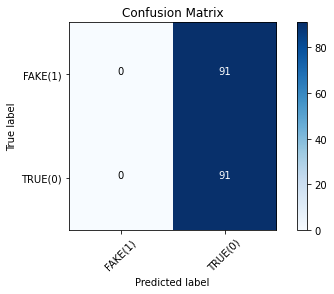

In [74]:
model = SVMModel
yPredict = model.predict(FNN_TestFeatures)

# Evaluation Metrics
cm = confusion_matrix (FNN_TestLabels, yPredict)
get_results(cm,FNN_TestLabels,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])

### 9.2.3 Naive Bayes

Accuracy: 54.95%
Precision: 0.7368421052631579
Recall: 0.945054945054945
F1 Score: 0.6771653543307087

 Confusion Matrix 
 [[14 77]
 [ 5 86]]
              precision    recall  f1-score   support

           0       0.74      0.15      0.25        91
           1       0.53      0.95      0.68        91

    accuracy                           0.55       182
   macro avg       0.63      0.55      0.47       182
weighted avg       0.63      0.55      0.47       182

Confusion matrix, without normalization


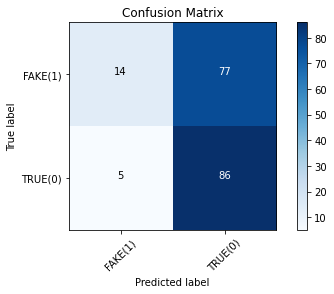

In [75]:
model = NBModel
yPredict = model.predict(FNN_TestFeatures)

# Evaluation Metrics
cm = confusion_matrix (FNN_TestLabels, yPredict)
get_results(cm,FNN_TestLabels,yPredict)
plot_confusion_matrix(cm,classes=['FAKE(1)','TRUE(0)'])